In [1]:
from imports import *
from keras.applications.vgg16 import VGG16
from sklearn.preprocessing import OneHotEncoder

C:\Users\leetw\Anaconda3\envs\keras\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
x = np.load('x_for_clustering.npy')
# x.shape
xx = []
for im in x:
#     print(im.shape)
    xx.append(cv2.resize(im, (224, 224)))
xx = np.stack(xx)
# xx.shape

In [3]:
yy = pd.read_csv('data_for_clustering.csv', header=None)[1]
yy.value_counts()
w = 1/yy.value_counts()
w

0     0.006579
4     0.009009
3     0.020000
2     0.037037
1     0.052632
10    0.066667
5     0.090909
6     0.200000
9     0.333333
8     0.333333
7     0.333333
Name: 1, dtype: float64

In [4]:
le = OneHotEncoder()
y = le.fit_transform(np.expand_dims(yy, axis=1)).todense()

In [5]:
x = x[yy.index]

In [6]:
# y.shape
# y.todense()

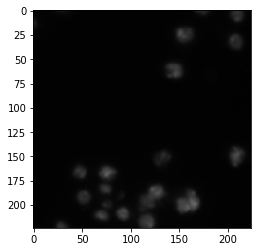

In [7]:
plt.imshow(xx[0])

In [8]:
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(128,128,3))

In [9]:
top_model = Sequential()
top_model.add(Flatten(input_shape=vgg16.output_shape[1:]))
top_model.add(Dense(512, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(11, activation='sigmoid'))
model = Model(input=vgg16.input, output=top_model(vgg16.output))

C:\Users\leetw\Anaconda3\envs\keras\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("se...)`
  


In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
__________

In [11]:
data_gen_args_img = dict(samplewise_center=True,
                     samplewise_std_normalization=True,
                     rotation_range=90.,
                     width_shift_range=0.2,
                     height_shift_range=0.2,
                     zoom_range=0.2, 
                     fill_mode="reflect")
image_datagen = ImageDataGenerator(**data_gen_args_img)
seed = 7
BATCH_SIZE = 8
LR_MIN = 1e-9
LR_INIT = 1e-3
image_datagen.fit(x, augment=True, seed=seed)
image_generator = image_datagen.flow(x, y, seed=seed, batch_size=BATCH_SIZE, shuffle=True)

In [12]:
# Compile model:
model.compile(optimizer=Adam(lr = LR_INIT), loss='binary_crossentropy', metrics=["accuracy"])

In [13]:
checkpointer = ModelCheckpoint('model-nuclei2018-1.h5', verbose=1, save_best_only=True)
# reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=LR_MIN, verbose=1) # search "learning rate"
def sched(epoch, lr):
    if epoch%20==0:
        lr = lr*0.8
    return lr
reduce_lr = keras.callbacks.LearningRateScheduler(sched, verbose=1)

In [ ]:
results = model.fit_generator(image_generator, epochs=10000, callbacks=[checkpointer, reduce_lr],
                              steps_per_epoch=x.shape[0]//BATCH_SIZE, class_weight=w,
                              verbose=1)

Epoch 1/10000

Epoch 00001: LearningRateScheduler reducing learning rate to 0.000800000037997961.
49/49 [==============================] - ETA: 6:33 - loss: 0.8624 - acc: 0.477 - ETA: 3:15 - loss: 0.6841 - acc: 0.613 - ETA: 2:08 - loss: 0.7760 - acc: 0.625 - ETA: 1:35 - loss: 0.7010 - acc: 0.664 - ETA: 1:15 - loss: 0.6503 - acc: 0.688 - ETA: 1:02 - loss: 0.5869 - acc: 0.727 - ETA: 52s - loss: 0.5833 - acc: 0.738 - ETA: 45s - loss: 0.5560 - acc: 0.74 - ETA: 40s - loss: 0.5340 - acc: 0.76 - ETA: 35s - loss: 0.5219 - acc: 0.77 - ETA: 31s - loss: 0.5035 - acc: 0.78 - ETA: 28s - loss: 0.4847 - acc: 0.79 - ETA: 26s - loss: 0.4710 - acc: 0.80 - ETA: 23s - loss: 0.4597 - acc: 0.80 - ETA: 21s - loss: 0.4533 - acc: 0.81 - ETA: 22s - loss: 0.4451 - acc: 0.81 - ETA: 20s - loss: 0.4348 - acc: 0.82 - ETA: 19s - loss: 0.4289 - acc: 0.82 - ETA: 17s - loss: 0.4217 - acc: 0.82 - ETA: 16s - loss: 0.4168 - acc: 0.82 - ETA: 15s - loss: 0.4147 - acc: 0.82 - ETA: 14s - loss: 0.4080 - acc: 0.83 - ETA: 13s - l

C:\Users\leetw\Anaconda3\envs\keras\lib\site-packages\keras\callbacks.py:435: RuntimeWarning: Can save best model only with val_loss available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


Epoch 2/10000

Epoch 00002: LearningRateScheduler reducing learning rate to 0.000800000037997961.
49/49 [==============================] - ETA: 5s - loss: 0.2655 - acc: 0.886 - ETA: 4s - loss: 0.2243 - acc: 0.892 - ETA: 4s - loss: 0.2262 - acc: 0.901 - ETA: 4s - loss: 0.2196 - acc: 0.900 - ETA: 4s - loss: 0.2423 - acc: 0.897 - ETA: 4s - loss: 0.2431 - acc: 0.895 - ETA: 4s - loss: 0.2545 - acc: 0.896 - ETA: 4s - loss: 0.2648 - acc: 0.889 - ETA: 4s - loss: 0.2699 - acc: 0.890 - ETA: 4s - loss: 0.2747 - acc: 0.889 - ETA: 3s - loss: 0.2704 - acc: 0.892 - ETA: 3s - loss: 0.2690 - acc: 0.893 - ETA: 3s - loss: 0.2662 - acc: 0.892 - ETA: 3s - loss: 0.2635 - acc: 0.894 - ETA: 3s - loss: 0.2604 - acc: 0.896 - ETA: 3s - loss: 0.2598 - acc: 0.897 - ETA: 3s - loss: 0.2617 - acc: 0.897 - ETA: 3s - loss: 0.2593 - acc: 0.899 - ETA: 3s - loss: 0.2590 - acc: 0.898 - ETA: 3s - loss: 0.2526 - acc: 0.901 - ETA: 2s - loss: 0.2523 - acc: 0.902 - ETA: 2s - loss: 0.2543 - acc: 0.900 - ETA: 2s - loss: 0.2570 - 

49/49 [==============================] - ETA: 4s - loss: 0.1821 - acc: 0.931 - ETA: 4s - loss: 0.1882 - acc: 0.926 - ETA: 4s - loss: 0.1811 - acc: 0.931 - ETA: 4s - loss: 0.1982 - acc: 0.926 - ETA: 4s - loss: 0.1973 - acc: 0.922 - ETA: 4s - loss: 0.1838 - acc: 0.928 - ETA: 4s - loss: 0.1819 - acc: 0.925 - ETA: 4s - loss: 0.1913 - acc: 0.924 - ETA: 4s - loss: 0.1919 - acc: 0.921 - ETA: 4s - loss: 0.1929 - acc: 0.919 - ETA: 4s - loss: 0.1895 - acc: 0.920 - ETA: 3s - loss: 0.1925 - acc: 0.920 - ETA: 3s - loss: 0.1891 - acc: 0.922 - ETA: 3s - loss: 0.1922 - acc: 0.922 - ETA: 3s - loss: 0.1921 - acc: 0.922 - ETA: 3s - loss: 0.1907 - acc: 0.920 - ETA: 3s - loss: 0.1946 - acc: 0.919 - ETA: 3s - loss: 0.1960 - acc: 0.919 - ETA: 3s - loss: 0.1960 - acc: 0.919 - ETA: 3s - loss: 0.1947 - acc: 0.920 - ETA: 2s - loss: 0.2003 - acc: 0.917 - ETA: 2s - loss: 0.2017 - acc: 0.916 - ETA: 2s - loss: 0.2024 - acc: 0.916 - ETA: 2s - loss: 0.2013 - acc: 0.915 - ETA: 2s - loss: 0.2019 - acc: 0.916 - ETA: 2s -

49/49 [==============================] - ETA: 4s - loss: 0.1789 - acc: 0.897 - ETA: 4s - loss: 0.2161 - acc: 0.880 - ETA: 4s - loss: 0.1990 - acc: 0.886 - ETA: 4s - loss: 0.2104 - acc: 0.889 - ETA: 4s - loss: 0.2379 - acc: 0.881 - ETA: 4s - loss: 0.2258 - acc: 0.892 - ETA: 4s - loss: 0.2270 - acc: 0.892 - ETA: 4s - loss: 0.2184 - acc: 0.896 - ETA: 4s - loss: 0.2080 - acc: 0.900 - ETA: 4s - loss: 0.2128 - acc: 0.902 - ETA: 3s - loss: 0.2098 - acc: 0.902 - ETA: 3s - loss: 0.2209 - acc: 0.903 - ETA: 3s - loss: 0.2183 - acc: 0.904 - ETA: 3s - loss: 0.2159 - acc: 0.906 - ETA: 3s - loss: 0.2117 - acc: 0.907 - ETA: 3s - loss: 0.2100 - acc: 0.907 - ETA: 3s - loss: 0.2088 - acc: 0.907 - ETA: 3s - loss: 0.2125 - acc: 0.905 - ETA: 3s - loss: 0.2104 - acc: 0.906 - ETA: 2s - loss: 0.2076 - acc: 0.906 - ETA: 2s - loss: 0.2059 - acc: 0.906 - ETA: 2s - loss: 0.2004 - acc: 0.909 - ETA: 2s - loss: 0.2103 - acc: 0.909 - ETA: 2s - loss: 0.2109 - acc: 0.911 - ETA: 2s - loss: 0.2125 - acc: 0.912 - ETA: 2s -

49/49 [==============================] - ETA: 4s - loss: 0.1616 - acc: 0.920 - ETA: 4s - loss: 0.1619 - acc: 0.909 - ETA: 4s - loss: 0.1599 - acc: 0.916 - ETA: 4s - loss: 0.1658 - acc: 0.917 - ETA: 4s - loss: 0.1648 - acc: 0.918 - ETA: 4s - loss: 0.1713 - acc: 0.912 - ETA: 4s - loss: 0.1667 - acc: 0.917 - ETA: 4s - loss: 0.1666 - acc: 0.914 - ETA: 4s - loss: 0.1683 - acc: 0.912 - ETA: 3s - loss: 0.1712 - acc: 0.910 - ETA: 3s - loss: 0.1739 - acc: 0.911 - ETA: 3s - loss: 0.1713 - acc: 0.911 - ETA: 3s - loss: 0.1714 - acc: 0.913 - ETA: 3s - loss: 0.1694 - acc: 0.912 - ETA: 3s - loss: 0.1695 - acc: 0.912 - ETA: 3s - loss: 0.1692 - acc: 0.912 - ETA: 3s - loss: 0.1665 - acc: 0.913 - ETA: 3s - loss: 0.1646 - acc: 0.914 - ETA: 3s - loss: 0.1658 - acc: 0.915 - ETA: 2s - loss: 0.1654 - acc: 0.914 - ETA: 2s - loss: 0.1689 - acc: 0.914 - ETA: 2s - loss: 0.1715 - acc: 0.914 - ETA: 2s - loss: 0.1729 - acc: 0.915 - ETA: 2s - loss: 0.1717 - acc: 0.915 - ETA: 2s - loss: 0.1739 - acc: 0.915 - ETA: 2s -

49/49 [==============================] - ETA: 4s - loss: 0.1264 - acc: 0.920 - ETA: 4s - loss: 0.1734 - acc: 0.903 - ETA: 4s - loss: 0.1769 - acc: 0.916 - ETA: 4s - loss: 0.1792 - acc: 0.917 - ETA: 4s - loss: 0.2097 - acc: 0.915 - ETA: 4s - loss: 0.2137 - acc: 0.914 - ETA: 4s - loss: 0.2037 - acc: 0.918 - ETA: 4s - loss: 0.2148 - acc: 0.916 - ETA: 4s - loss: 0.2146 - acc: 0.914 - ETA: 3s - loss: 0.2144 - acc: 0.913 - ETA: 3s - loss: 0.2147 - acc: 0.910 - ETA: 3s - loss: 0.2091 - acc: 0.910 - ETA: 3s - loss: 0.2100 - acc: 0.910 - ETA: 3s - loss: 0.2043 - acc: 0.912 - ETA: 3s - loss: 0.2035 - acc: 0.915 - ETA: 3s - loss: 0.2014 - acc: 0.914 - ETA: 3s - loss: 0.1990 - acc: 0.914 - ETA: 3s - loss: 0.2001 - acc: 0.915 - ETA: 3s - loss: 0.2002 - acc: 0.915 - ETA: 2s - loss: 0.2011 - acc: 0.915 - ETA: 2s - loss: 0.2006 - acc: 0.915 - ETA: 2s - loss: 0.2002 - acc: 0.915 - ETA: 2s - loss: 0.1979 - acc: 0.915 - ETA: 2s - loss: 0.1975 - acc: 0.914 - ETA: 2s - loss: 0.1972 - acc: 0.914 - ETA: 2s -

49/49 [==============================] - ETA: 4s - loss: 0.1704 - acc: 0.897 - ETA: 4s - loss: 0.1874 - acc: 0.903 - ETA: 4s - loss: 0.1611 - acc: 0.924 - ETA: 4s - loss: 0.1561 - acc: 0.929 - ETA: 4s - loss: 0.1703 - acc: 0.925 - ETA: 4s - loss: 0.1606 - acc: 0.933 - ETA: 4s - loss: 0.1570 - acc: 0.938 - ETA: 4s - loss: 0.1669 - acc: 0.934 - ETA: 4s - loss: 0.1666 - acc: 0.930 - ETA: 3s - loss: 0.1704 - acc: 0.927 - ETA: 3s - loss: 0.1688 - acc: 0.928 - ETA: 3s - loss: 0.1639 - acc: 0.930 - ETA: 3s - loss: 0.1641 - acc: 0.932 - ETA: 3s - loss: 0.1619 - acc: 0.933 - ETA: 3s - loss: 0.1663 - acc: 0.934 - ETA: 3s - loss: 0.1627 - acc: 0.935 - ETA: 3s - loss: 0.1635 - acc: 0.933 - ETA: 3s - loss: 0.1690 - acc: 0.931 - ETA: 3s - loss: 0.1644 - acc: 0.934 - ETA: 2s - loss: 0.1652 - acc: 0.935 - ETA: 2s - loss: 0.1643 - acc: 0.935 - ETA: 2s - loss: 0.1710 - acc: 0.932 - ETA: 2s - loss: 0.1730 - acc: 0.932 - ETA: 2s - loss: 0.1727 - acc: 0.933 - ETA: 2s - loss: 0.1741 - acc: 0.930 - ETA: 2s -

49/49 [==============================] - ETA: 5s - loss: 0.1306 - acc: 0.954 - ETA: 4s - loss: 0.1458 - acc: 0.943 - ETA: 4s - loss: 0.1433 - acc: 0.954 - ETA: 4s - loss: 0.1366 - acc: 0.960 - ETA: 4s - loss: 0.1452 - acc: 0.956 - ETA: 4s - loss: 0.1489 - acc: 0.952 - ETA: 4s - loss: 0.1398 - acc: 0.956 - ETA: 4s - loss: 0.1387 - acc: 0.954 - ETA: 4s - loss: 0.1326 - acc: 0.955 - ETA: 3s - loss: 0.1428 - acc: 0.953 - ETA: 3s - loss: 0.1449 - acc: 0.952 - ETA: 3s - loss: 0.1447 - acc: 0.951 - ETA: 3s - loss: 0.1438 - acc: 0.951 - ETA: 3s - loss: 0.1438 - acc: 0.950 - ETA: 3s - loss: 0.1458 - acc: 0.949 - ETA: 3s - loss: 0.1473 - acc: 0.947 - ETA: 3s - loss: 0.1438 - acc: 0.949 - ETA: 3s - loss: 0.1479 - acc: 0.947 - ETA: 3s - loss: 0.1493 - acc: 0.945 - ETA: 2s - loss: 0.1465 - acc: 0.945 - ETA: 2s - loss: 0.1464 - acc: 0.945 - ETA: 2s - loss: 0.1465 - acc: 0.945 - ETA: 2s - loss: 0.1460 - acc: 0.945 - ETA: 2s - loss: 0.1441 - acc: 0.946 - ETA: 2s - loss: 0.1483 - acc: 0.945 - ETA: 2s -

49/49 [==============================] - ETA: 4s - loss: 0.1008 - acc: 0.943 - ETA: 4s - loss: 0.1517 - acc: 0.926 - ETA: 4s - loss: 0.1641 - acc: 0.931 - ETA: 4s - loss: 0.1585 - acc: 0.940 - ETA: 4s - loss: 0.1440 - acc: 0.945 - ETA: 4s - loss: 0.1388 - acc: 0.948 - ETA: 4s - loss: 0.1417 - acc: 0.948 - ETA: 4s - loss: 0.1456 - acc: 0.947 - ETA: 4s - loss: 0.1579 - acc: 0.940 - ETA: 3s - loss: 0.1612 - acc: 0.937 - ETA: 3s - loss: 0.1618 - acc: 0.933 - ETA: 3s - loss: 0.1696 - acc: 0.930 - ETA: 3s - loss: 0.1662 - acc: 0.931 - ETA: 3s - loss: 0.1624 - acc: 0.935 - ETA: 3s - loss: 0.1699 - acc: 0.933 - ETA: 3s - loss: 0.1733 - acc: 0.933 - ETA: 3s - loss: 0.1739 - acc: 0.935 - ETA: 3s - loss: 0.1690 - acc: 0.938 - ETA: 3s - loss: 0.1652 - acc: 0.939 - ETA: 2s - loss: 0.1639 - acc: 0.939 - ETA: 2s - loss: 0.1615 - acc: 0.941 - ETA: 2s - loss: 0.1606 - acc: 0.941 - ETA: 2s - loss: 0.1639 - acc: 0.941 - ETA: 2s - loss: 0.1624 - acc: 0.940 - ETA: 2s - loss: 0.1583 - acc: 0.942 - ETA: 2s -

49/49 [==============================] - ETA: 4s - loss: 0.1621 - acc: 0.931 - ETA: 4s - loss: 0.1822 - acc: 0.937 - ETA: 4s - loss: 0.2170 - acc: 0.928 - ETA: 4s - loss: 0.2316 - acc: 0.926 - ETA: 4s - loss: 0.2071 - acc: 0.927 - ETA: 4s - loss: 0.1922 - acc: 0.934 - ETA: 4s - loss: 0.1834 - acc: 0.933 - ETA: 4s - loss: 0.1808 - acc: 0.934 - ETA: 4s - loss: 0.1804 - acc: 0.933 - ETA: 4s - loss: 0.1788 - acc: 0.933 - ETA: 3s - loss: 0.1821 - acc: 0.932 - ETA: 3s - loss: 0.1760 - acc: 0.933 - ETA: 3s - loss: 0.1808 - acc: 0.932 - ETA: 3s - loss: 0.1765 - acc: 0.933 - ETA: 3s - loss: 0.1779 - acc: 0.931 - ETA: 3s - loss: 0.1767 - acc: 0.930 - ETA: 3s - loss: 0.1753 - acc: 0.930 - ETA: 3s - loss: 0.1769 - acc: 0.927 - ETA: 3s - loss: 0.1757 - acc: 0.926 - ETA: 3s - loss: 0.1746 - acc: 0.927 - ETA: 2s - loss: 0.1755 - acc: 0.925 - ETA: 2s - loss: 0.1765 - acc: 0.924 - ETA: 2s - loss: 0.1757 - acc: 0.924 - ETA: 2s - loss: 0.1748 - acc: 0.924 - ETA: 2s - loss: 0.1725 - acc: 0.925 - ETA: 2s -

49/49 [==============================] - ETA: 4s - loss: 0.1388 - acc: 0.909 - ETA: 4s - loss: 0.1328 - acc: 0.926 - ETA: 4s - loss: 0.1247 - acc: 0.939 - ETA: 4s - loss: 0.1347 - acc: 0.934 - ETA: 4s - loss: 0.1297 - acc: 0.940 - ETA: 4s - loss: 0.1160 - acc: 0.950 - ETA: 4s - loss: 0.1252 - acc: 0.946 - ETA: 4s - loss: 0.1377 - acc: 0.943 - ETA: 4s - loss: 0.1305 - acc: 0.947 - ETA: 3s - loss: 0.1357 - acc: 0.944 - ETA: 3s - loss: 0.1476 - acc: 0.942 - ETA: 3s - loss: 0.1452 - acc: 0.943 - ETA: 3s - loss: 0.1491 - acc: 0.941 - ETA: 3s - loss: 0.1500 - acc: 0.941 - ETA: 3s - loss: 0.1463 - acc: 0.943 - ETA: 3s - loss: 0.1469 - acc: 0.943 - ETA: 3s - loss: 0.1486 - acc: 0.945 - ETA: 3s - loss: 0.1517 - acc: 0.943 - ETA: 3s - loss: 0.1541 - acc: 0.943 - ETA: 2s - loss: 0.1493 - acc: 0.946 - ETA: 2s - loss: 0.1467 - acc: 0.946 - ETA: 2s - loss: 0.1549 - acc: 0.942 - ETA: 2s - loss: 0.1540 - acc: 0.942 - ETA: 2s - loss: 0.1564 - acc: 0.941 - ETA: 2s - loss: 0.1566 - acc: 0.940 - ETA: 2s -

49/49 [==============================] - ETA: 4s - loss: 0.1700 - acc: 0.909 - ETA: 4s - loss: 0.1658 - acc: 0.920 - ETA: 4s - loss: 0.1621 - acc: 0.935 - ETA: 4s - loss: 0.1608 - acc: 0.943 - ETA: 4s - loss: 0.1491 - acc: 0.947 - ETA: 4s - loss: 0.1471 - acc: 0.950 - ETA: 4s - loss: 0.1423 - acc: 0.952 - ETA: 4s - loss: 0.1475 - acc: 0.946 - ETA: 4s - loss: 0.1448 - acc: 0.945 - ETA: 4s - loss: 0.1475 - acc: 0.945 - ETA: 3s - loss: 0.1468 - acc: 0.942 - ETA: 3s - loss: 0.1436 - acc: 0.944 - ETA: 3s - loss: 0.1395 - acc: 0.944 - ETA: 3s - loss: 0.1416 - acc: 0.942 - ETA: 3s - loss: 0.1374 - acc: 0.943 - ETA: 3s - loss: 0.1397 - acc: 0.942 - ETA: 3s - loss: 0.1396 - acc: 0.941 - ETA: 3s - loss: 0.1378 - acc: 0.943 - ETA: 3s - loss: 0.1486 - acc: 0.942 - ETA: 3s - loss: 0.1455 - acc: 0.944 - ETA: 2s - loss: 0.1429 - acc: 0.945 - ETA: 2s - loss: 0.1465 - acc: 0.944 - ETA: 2s - loss: 0.1474 - acc: 0.944 - ETA: 2s - loss: 0.1490 - acc: 0.943 - ETA: 2s - loss: 0.1477 - acc: 0.943 - ETA: 2s -

49/49 [==============================] - ETA: 5s - loss: 0.1421 - acc: 0.920 - ETA: 4s - loss: 0.1762 - acc: 0.931 - ETA: 4s - loss: 0.1618 - acc: 0.943 - ETA: 4s - loss: 0.1352 - acc: 0.957 - ETA: 4s - loss: 0.1396 - acc: 0.952 - ETA: 4s - loss: 0.1389 - acc: 0.952 - ETA: 4s - loss: 0.1304 - acc: 0.952 - ETA: 4s - loss: 0.1265 - acc: 0.954 - ETA: 4s - loss: 0.1365 - acc: 0.950 - ETA: 4s - loss: 0.1412 - acc: 0.952 - ETA: 3s - loss: 0.1481 - acc: 0.948 - ETA: 3s - loss: 0.1454 - acc: 0.947 - ETA: 3s - loss: 0.1449 - acc: 0.948 - ETA: 3s - loss: 0.1442 - acc: 0.947 - ETA: 3s - loss: 0.1442 - acc: 0.947 - ETA: 3s - loss: 0.1395 - acc: 0.950 - ETA: 3s - loss: 0.1350 - acc: 0.952 - ETA: 3s - loss: 0.1343 - acc: 0.953 - ETA: 3s - loss: 0.1311 - acc: 0.954 - ETA: 3s - loss: 0.1360 - acc: 0.954 - ETA: 2s - loss: 0.1383 - acc: 0.954 - ETA: 2s - loss: 0.1391 - acc: 0.953 - ETA: 2s - loss: 0.1392 - acc: 0.952 - ETA: 2s - loss: 0.1402 - acc: 0.949 - ETA: 2s - loss: 0.1374 - acc: 0.951 - ETA: 2s -

49/49 [==============================] - ETA: 4s - loss: 0.1534 - acc: 0.931 - ETA: 4s - loss: 0.1391 - acc: 0.937 - ETA: 4s - loss: 0.1470 - acc: 0.939 - ETA: 4s - loss: 0.1701 - acc: 0.940 - ETA: 4s - loss: 0.1489 - acc: 0.950 - ETA: 4s - loss: 0.1637 - acc: 0.941 - ETA: 4s - loss: 0.1581 - acc: 0.943 - ETA: 4s - loss: 0.1717 - acc: 0.938 - ETA: 4s - loss: 0.1800 - acc: 0.934 - ETA: 4s - loss: 0.1790 - acc: 0.935 - ETA: 3s - loss: 0.1708 - acc: 0.939 - ETA: 3s - loss: 0.1685 - acc: 0.938 - ETA: 3s - loss: 0.1653 - acc: 0.941 - ETA: 3s - loss: 0.1620 - acc: 0.941 - ETA: 3s - loss: 0.1569 - acc: 0.944 - ETA: 3s - loss: 0.1565 - acc: 0.944 - ETA: 3s - loss: 0.1531 - acc: 0.946 - ETA: 3s - loss: 0.1508 - acc: 0.945 - ETA: 3s - loss: 0.1532 - acc: 0.944 - ETA: 3s - loss: 0.1548 - acc: 0.944 - ETA: 2s - loss: 0.1550 - acc: 0.944 - ETA: 2s - loss: 0.1590 - acc: 0.942 - ETA: 2s - loss: 0.1573 - acc: 0.943 - ETA: 2s - loss: 0.1562 - acc: 0.943 - ETA: 2s - loss: 0.1572 - acc: 0.943 - ETA: 2s -

49/49 [==============================] - ETA: 4s - loss: 0.1306 - acc: 0.954 - ETA: 4s - loss: 0.1258 - acc: 0.948 - ETA: 4s - loss: 0.1228 - acc: 0.947 - ETA: 4s - loss: 0.1344 - acc: 0.946 - ETA: 4s - loss: 0.1249 - acc: 0.945 - ETA: 4s - loss: 0.1299 - acc: 0.943 - ETA: 4s - loss: 0.1343 - acc: 0.944 - ETA: 4s - loss: 0.1348 - acc: 0.946 - ETA: 4s - loss: 0.1406 - acc: 0.943 - ETA: 4s - loss: 0.1428 - acc: 0.944 - ETA: 3s - loss: 0.1376 - acc: 0.947 - ETA: 3s - loss: 0.1406 - acc: 0.945 - ETA: 3s - loss: 0.1332 - acc: 0.949 - ETA: 3s - loss: 0.1294 - acc: 0.951 - ETA: 3s - loss: 0.1296 - acc: 0.950 - ETA: 3s - loss: 0.1297 - acc: 0.950 - ETA: 3s - loss: 0.1288 - acc: 0.951 - ETA: 3s - loss: 0.1306 - acc: 0.952 - ETA: 3s - loss: 0.1352 - acc: 0.951 - ETA: 3s - loss: 0.1394 - acc: 0.948 - ETA: 2s - loss: 0.1396 - acc: 0.948 - ETA: 2s - loss: 0.1426 - acc: 0.947 - ETA: 2s - loss: 0.1444 - acc: 0.946 - ETA: 2s - loss: 0.1428 - acc: 0.947 - ETA: 2s - loss: 0.1434 - acc: 0.947 - ETA: 2s -

49/49 [==============================] - ETA: 4s - loss: 0.1484 - acc: 0.954 - ETA: 4s - loss: 0.1191 - acc: 0.965 - ETA: 4s - loss: 0.1015 - acc: 0.973 - ETA: 4s - loss: 0.1087 - acc: 0.968 - ETA: 4s - loss: 0.1496 - acc: 0.956 - ETA: 4s - loss: 0.1507 - acc: 0.958 - ETA: 4s - loss: 0.1464 - acc: 0.956 - ETA: 4s - loss: 0.1532 - acc: 0.950 - ETA: 4s - loss: 0.1495 - acc: 0.952 - ETA: 4s - loss: 0.1461 - acc: 0.951 - ETA: 3s - loss: 0.1521 - acc: 0.946 - ETA: 3s - loss: 0.1479 - acc: 0.948 - ETA: 3s - loss: 0.1425 - acc: 0.951 - ETA: 3s - loss: 0.1391 - acc: 0.952 - ETA: 3s - loss: 0.1337 - acc: 0.955 - ETA: 3s - loss: 0.1366 - acc: 0.953 - ETA: 3s - loss: 0.1370 - acc: 0.953 - ETA: 3s - loss: 0.1378 - acc: 0.952 - ETA: 3s - loss: 0.1354 - acc: 0.953 - ETA: 2s - loss: 0.1377 - acc: 0.952 - ETA: 2s - loss: 0.1353 - acc: 0.954 - ETA: 2s - loss: 0.1336 - acc: 0.954 - ETA: 2s - loss: 0.1351 - acc: 0.953 - ETA: 2s - loss: 0.1336 - acc: 0.953 - ETA: 2s - loss: 0.1345 - acc: 0.954 - ETA: 2s -

49/49 [==============================] - ETA: 5s - loss: 0.1326 - acc: 0.943 - ETA: 4s - loss: 0.1751 - acc: 0.926 - ETA: 4s - loss: 0.2012 - acc: 0.916 - ETA: 4s - loss: 0.1718 - acc: 0.931 - ETA: 4s - loss: 0.1647 - acc: 0.931 - ETA: 4s - loss: 0.1578 - acc: 0.939 - ETA: 4s - loss: 0.1682 - acc: 0.933 - ETA: 4s - loss: 0.1604 - acc: 0.937 - ETA: 4s - loss: 0.1643 - acc: 0.938 - ETA: 4s - loss: 0.1640 - acc: 0.938 - ETA: 3s - loss: 0.1694 - acc: 0.937 - ETA: 3s - loss: 0.1744 - acc: 0.934 - ETA: 3s - loss: 0.1704 - acc: 0.935 - ETA: 3s - loss: 0.1707 - acc: 0.936 - ETA: 3s - loss: 0.1644 - acc: 0.939 - ETA: 3s - loss: 0.1611 - acc: 0.941 - ETA: 3s - loss: 0.1619 - acc: 0.941 - ETA: 3s - loss: 0.1569 - acc: 0.943 - ETA: 3s - loss: 0.1561 - acc: 0.943 - ETA: 3s - loss: 0.1572 - acc: 0.943 - ETA: 2s - loss: 0.1536 - acc: 0.944 - ETA: 2s - loss: 0.1514 - acc: 0.945 - ETA: 2s - loss: 0.1503 - acc: 0.945 - ETA: 2s - loss: 0.1509 - acc: 0.945 - ETA: 2s - loss: 0.1509 - acc: 0.946 - ETA: 2s -

49/49 [==============================] - ETA: 5s - loss: 0.1516 - acc: 0.943 - ETA: 4s - loss: 0.2042 - acc: 0.920 - ETA: 4s - loss: 0.2254 - acc: 0.912 - ETA: 4s - loss: 0.2038 - acc: 0.923 - ETA: 4s - loss: 0.1826 - acc: 0.931 - ETA: 4s - loss: 0.1816 - acc: 0.929 - ETA: 4s - loss: 0.1789 - acc: 0.931 - ETA: 4s - loss: 0.1712 - acc: 0.931 - ETA: 4s - loss: 0.1573 - acc: 0.939 - ETA: 4s - loss: 0.1503 - acc: 0.942 - ETA: 3s - loss: 0.1457 - acc: 0.943 - ETA: 3s - loss: 0.1444 - acc: 0.944 - ETA: 3s - loss: 0.1483 - acc: 0.945 - ETA: 3s - loss: 0.1446 - acc: 0.947 - ETA: 3s - loss: 0.1491 - acc: 0.946 - ETA: 3s - loss: 0.1459 - acc: 0.948 - ETA: 3s - loss: 0.1458 - acc: 0.947 - ETA: 3s - loss: 0.1436 - acc: 0.948 - ETA: 3s - loss: 0.1480 - acc: 0.946 - ETA: 3s - loss: 0.1479 - acc: 0.946 - ETA: 2s - loss: 0.1482 - acc: 0.945 - ETA: 2s - loss: 0.1462 - acc: 0.946 - ETA: 2s - loss: 0.1468 - acc: 0.945 - ETA: 2s - loss: 0.1462 - acc: 0.946 - ETA: 2s - loss: 0.1471 - acc: 0.945 - ETA: 2s -

49/49 [==============================] - ETA: 4s - loss: 0.1096 - acc: 0.954 - ETA: 4s - loss: 0.1212 - acc: 0.957 - ETA: 4s - loss: 0.1424 - acc: 0.956 - ETA: 4s - loss: 0.1640 - acc: 0.950 - ETA: 4s - loss: 0.1697 - acc: 0.944 - ETA: 4s - loss: 0.1725 - acc: 0.936 - ETA: 4s - loss: 0.1598 - acc: 0.942 - ETA: 4s - loss: 0.1561 - acc: 0.944 - ETA: 4s - loss: 0.1486 - acc: 0.945 - ETA: 4s - loss: 0.1432 - acc: 0.948 - ETA: 3s - loss: 0.1405 - acc: 0.948 - ETA: 3s - loss: 0.1366 - acc: 0.949 - ETA: 3s - loss: 0.1379 - acc: 0.949 - ETA: 3s - loss: 0.1375 - acc: 0.950 - ETA: 3s - loss: 0.1412 - acc: 0.947 - ETA: 3s - loss: 0.1384 - acc: 0.947 - ETA: 3s - loss: 0.1379 - acc: 0.946 - ETA: 3s - loss: 0.1423 - acc: 0.946 - ETA: 3s - loss: 0.1380 - acc: 0.948 - ETA: 2s - loss: 0.1368 - acc: 0.949 - ETA: 2s - loss: 0.1412 - acc: 0.947 - ETA: 2s - loss: 0.1397 - acc: 0.947 - ETA: 2s - loss: 0.1381 - acc: 0.948 - ETA: 2s - loss: 0.1356 - acc: 0.949 - ETA: 2s - loss: 0.1362 - acc: 0.948 - ETA: 2s -

49/49 [==============================] - ETA: 6s - loss: 0.2135 - acc: 0.954 - ETA: 7s - loss: 0.2421 - acc: 0.920 - ETA: 9s - loss: 0.2098 - acc: 0.920 - ETA: 8s - loss: 0.1965 - acc: 0.923 - ETA: 7s - loss: 0.1775 - acc: 0.931 - ETA: 7s - loss: 0.1664 - acc: 0.935 - ETA: 7s - loss: 0.1723 - acc: 0.935 - ETA: 6s - loss: 0.1813 - acc: 0.933 - ETA: 7s - loss: 0.1711 - acc: 0.935 - ETA: 6s - loss: 0.1643 - acc: 0.938 - ETA: 6s - loss: 0.1639 - acc: 0.937 - ETA: 5s - loss: 0.1602 - acc: 0.940 - ETA: 5s - loss: 0.1590 - acc: 0.939 - ETA: 5s - loss: 0.1557 - acc: 0.939 - ETA: 5s - loss: 0.1481 - acc: 0.943 - ETA: 5s - loss: 0.1556 - acc: 0.941 - ETA: 5s - loss: 0.1562 - acc: 0.941 - ETA: 4s - loss: 0.1556 - acc: 0.942 - ETA: 4s - loss: 0.1552 - acc: 0.943 - ETA: 4s - loss: 0.1536 - acc: 0.942 - ETA: 4s - loss: 0.1516 - acc: 0.944 - ETA: 3s - loss: 0.1525 - acc: 0.943 - ETA: 3s - loss: 0.1503 - acc: 0.944 - ETA: 3s - loss: 0.1497 - acc: 0.944 - ETA: 3s - loss: 0.1469 - acc: 0.946 - ETA: 3s -

49/49 [==============================] - ETA: 7s - loss: 0.3840 - acc: 0.875 - ETA: 7s - loss: 0.2218 - acc: 0.937 - ETA: 6s - loss: 0.1913 - acc: 0.943 - ETA: 6s - loss: 0.1760 - acc: 0.943 - ETA: 6s - loss: 0.1613 - acc: 0.947 - ETA: 7s - loss: 0.1431 - acc: 0.956 - ETA: 8s - loss: 0.1365 - acc: 0.959 - ETA: 8s - loss: 0.1525 - acc: 0.954 - ETA: 7s - loss: 0.1462 - acc: 0.957 - ETA: 7s - loss: 0.1399 - acc: 0.958 - ETA: 7s - loss: 0.1362 - acc: 0.958 - ETA: 7s - loss: 0.1335 - acc: 0.958 - ETA: 6s - loss: 0.1350 - acc: 0.955 - ETA: 6s - loss: 0.1376 - acc: 0.955 - ETA: 6s - loss: 0.1354 - acc: 0.956 - ETA: 5s - loss: 0.1378 - acc: 0.955 - ETA: 5s - loss: 0.1351 - acc: 0.954 - ETA: 6s - loss: 0.1376 - acc: 0.953 - ETA: 5s - loss: 0.1373 - acc: 0.953 - ETA: 5s - loss: 0.1386 - acc: 0.953 - ETA: 5s - loss: 0.1369 - acc: 0.954 - ETA: 4s - loss: 0.1380 - acc: 0.954 - ETA: 4s - loss: 0.1365 - acc: 0.955 - ETA: 4s - loss: 0.1367 - acc: 0.955 - ETA: 4s - loss: 0.1378 - acc: 0.954 - ETA: 3s -

49/49 [==============================] - ETA: 4s - loss: 0.2091 - acc: 0.920 - ETA: 4s - loss: 0.1458 - acc: 0.948 - ETA: 4s - loss: 0.1210 - acc: 0.962 - ETA: 4s - loss: 0.1166 - acc: 0.957 - ETA: 4s - loss: 0.1148 - acc: 0.956 - ETA: 4s - loss: 0.1332 - acc: 0.954 - ETA: 4s - loss: 0.1224 - acc: 0.957 - ETA: 4s - loss: 0.1252 - acc: 0.957 - ETA: 4s - loss: 0.1314 - acc: 0.958 - ETA: 4s - loss: 0.1349 - acc: 0.953 - ETA: 3s - loss: 0.1357 - acc: 0.953 - ETA: 3s - loss: 0.1431 - acc: 0.950 - ETA: 3s - loss: 0.1451 - acc: 0.948 - ETA: 3s - loss: 0.1389 - acc: 0.950 - ETA: 3s - loss: 0.1383 - acc: 0.950 - ETA: 3s - loss: 0.1361 - acc: 0.953 - ETA: 3s - loss: 0.1349 - acc: 0.953 - ETA: 3s - loss: 0.1352 - acc: 0.953 - ETA: 3s - loss: 0.1324 - acc: 0.955 - ETA: 2s - loss: 0.1331 - acc: 0.955 - ETA: 2s - loss: 0.1307 - acc: 0.956 - ETA: 2s - loss: 0.1325 - acc: 0.955 - ETA: 2s - loss: 0.1342 - acc: 0.954 - ETA: 2s - loss: 0.1379 - acc: 0.953 - ETA: 2s - loss: 0.1369 - acc: 0.953 - ETA: 2s -

49/49 [==============================] - ETA: 5s - loss: 0.1976 - acc: 0.943 - ETA: 4s - loss: 0.1652 - acc: 0.960 - ETA: 4s - loss: 0.1562 - acc: 0.962 - ETA: 4s - loss: 0.1386 - acc: 0.965 - ETA: 4s - loss: 0.1600 - acc: 0.961 - ETA: 4s - loss: 0.1596 - acc: 0.956 - ETA: 4s - loss: 0.1573 - acc: 0.954 - ETA: 4s - loss: 0.1575 - acc: 0.951 - ETA: 4s - loss: 0.1578 - acc: 0.950 - ETA: 4s - loss: 0.1571 - acc: 0.947 - ETA: 3s - loss: 0.1577 - acc: 0.946 - ETA: 3s - loss: 0.1548 - acc: 0.947 - ETA: 3s - loss: 0.1589 - acc: 0.944 - ETA: 3s - loss: 0.1534 - acc: 0.945 - ETA: 3s - loss: 0.1522 - acc: 0.947 - ETA: 3s - loss: 0.1501 - acc: 0.948 - ETA: 3s - loss: 0.1462 - acc: 0.949 - ETA: 3s - loss: 0.1430 - acc: 0.951 - ETA: 3s - loss: 0.1423 - acc: 0.951 - ETA: 2s - loss: 0.1400 - acc: 0.952 - ETA: 2s - loss: 0.1383 - acc: 0.952 - ETA: 2s - loss: 0.1388 - acc: 0.951 - ETA: 2s - loss: 0.1435 - acc: 0.949 - ETA: 2s - loss: 0.1422 - acc: 0.950 - ETA: 2s - loss: 0.1401 - acc: 0.950 - ETA: 2s -

49/49 [==============================] - ETA: 5s - loss: 0.1128 - acc: 0.965 - ETA: 4s - loss: 0.1464 - acc: 0.937 - ETA: 4s - loss: 0.1238 - acc: 0.947 - ETA: 4s - loss: 0.1399 - acc: 0.943 - ETA: 4s - loss: 0.1265 - acc: 0.950 - ETA: 4s - loss: 0.1400 - acc: 0.950 - ETA: 4s - loss: 0.1386 - acc: 0.951 - ETA: 4s - loss: 0.1417 - acc: 0.950 - ETA: 4s - loss: 0.1387 - acc: 0.950 - ETA: 4s - loss: 0.1299 - acc: 0.954 - ETA: 3s - loss: 0.1275 - acc: 0.955 - ETA: 3s - loss: 0.1346 - acc: 0.951 - ETA: 3s - loss: 0.1319 - acc: 0.952 - ETA: 3s - loss: 0.1260 - acc: 0.956 - ETA: 3s - loss: 0.1251 - acc: 0.955 - ETA: 3s - loss: 0.1294 - acc: 0.953 - ETA: 3s - loss: 0.1328 - acc: 0.951 - ETA: 3s - loss: 0.1370 - acc: 0.949 - ETA: 3s - loss: 0.1418 - acc: 0.948 - ETA: 2s - loss: 0.1408 - acc: 0.948 - ETA: 2s - loss: 0.1395 - acc: 0.949 - ETA: 2s - loss: 0.1388 - acc: 0.948 - ETA: 2s - loss: 0.1394 - acc: 0.948 - ETA: 2s - loss: 0.1423 - acc: 0.947 - ETA: 2s - loss: 0.1462 - acc: 0.946 - ETA: 2s -

49/49 [==============================] - ETA: 4s - loss: 0.2473 - acc: 0.896 - ETA: 4s - loss: 0.1842 - acc: 0.931 - ETA: 4s - loss: 0.1649 - acc: 0.938 - ETA: 4s - loss: 0.1635 - acc: 0.942 - ETA: 4s - loss: 0.1538 - acc: 0.945 - ETA: 4s - loss: 0.1483 - acc: 0.944 - ETA: 4s - loss: 0.1473 - acc: 0.946 - ETA: 4s - loss: 0.1473 - acc: 0.943 - ETA: 4s - loss: 0.1475 - acc: 0.944 - ETA: 4s - loss: 0.1397 - acc: 0.948 - ETA: 3s - loss: 0.1503 - acc: 0.944 - ETA: 3s - loss: 0.1459 - acc: 0.945 - ETA: 3s - loss: 0.1504 - acc: 0.943 - ETA: 3s - loss: 0.1449 - acc: 0.946 - ETA: 3s - loss: 0.1445 - acc: 0.946 - ETA: 3s - loss: 0.1407 - acc: 0.947 - ETA: 3s - loss: 0.1386 - acc: 0.948 - ETA: 3s - loss: 0.1400 - acc: 0.948 - ETA: 3s - loss: 0.1386 - acc: 0.947 - ETA: 2s - loss: 0.1351 - acc: 0.948 - ETA: 2s - loss: 0.1351 - acc: 0.949 - ETA: 2s - loss: 0.1338 - acc: 0.949 - ETA: 2s - loss: 0.1386 - acc: 0.948 - ETA: 2s - loss: 0.1404 - acc: 0.947 - ETA: 2s - loss: 0.1400 - acc: 0.947 - ETA: 2s -

49/49 [==============================] - ETA: 4s - loss: 0.0590 - acc: 0.988 - ETA: 4s - loss: 0.1054 - acc: 0.971 - ETA: 4s - loss: 0.1494 - acc: 0.943 - ETA: 4s - loss: 0.1610 - acc: 0.940 - ETA: 4s - loss: 0.1550 - acc: 0.940 - ETA: 4s - loss: 0.1547 - acc: 0.939 - ETA: 4s - loss: 0.1530 - acc: 0.942 - ETA: 4s - loss: 0.1495 - acc: 0.942 - ETA: 4s - loss: 0.1472 - acc: 0.943 - ETA: 3s - loss: 0.1549 - acc: 0.943 - ETA: 3s - loss: 0.1471 - acc: 0.947 - ETA: 3s - loss: 0.1422 - acc: 0.950 - ETA: 3s - loss: 0.1380 - acc: 0.952 - ETA: 3s - loss: 0.1388 - acc: 0.954 - ETA: 3s - loss: 0.1339 - acc: 0.956 - ETA: 3s - loss: 0.1341 - acc: 0.955 - ETA: 3s - loss: 0.1345 - acc: 0.955 - ETA: 3s - loss: 0.1326 - acc: 0.956 - ETA: 3s - loss: 0.1348 - acc: 0.955 - ETA: 2s - loss: 0.1347 - acc: 0.954 - ETA: 2s - loss: 0.1366 - acc: 0.953 - ETA: 2s - loss: 0.1384 - acc: 0.952 - ETA: 2s - loss: 0.1386 - acc: 0.952 - ETA: 2s - loss: 0.1364 - acc: 0.953 - ETA: 2s - loss: 0.1347 - acc: 0.953 - ETA: 2s -

49/49 [==============================] - ETA: 4s - loss: 0.1059 - acc: 0.954 - ETA: 4s - loss: 0.1395 - acc: 0.951 - ETA: 4s - loss: 0.1295 - acc: 0.952 - ETA: 4s - loss: 0.1456 - acc: 0.938 - ETA: 4s - loss: 0.1419 - acc: 0.946 - ETA: 4s - loss: 0.1329 - acc: 0.951 - ETA: 4s - loss: 0.1354 - acc: 0.948 - ETA: 4s - loss: 0.1440 - acc: 0.946 - ETA: 4s - loss: 0.1415 - acc: 0.948 - ETA: 4s - loss: 0.1401 - acc: 0.949 - ETA: 3s - loss: 0.1407 - acc: 0.949 - ETA: 3s - loss: 0.1390 - acc: 0.951 - ETA: 3s - loss: 0.1380 - acc: 0.951 - ETA: 3s - loss: 0.1336 - acc: 0.953 - ETA: 3s - loss: 0.1338 - acc: 0.951 - ETA: 3s - loss: 0.1331 - acc: 0.951 - ETA: 3s - loss: 0.1303 - acc: 0.953 - ETA: 3s - loss: 0.1351 - acc: 0.951 - ETA: 3s - loss: 0.1322 - acc: 0.952 - ETA: 2s - loss: 0.1278 - acc: 0.954 - ETA: 2s - loss: 0.1264 - acc: 0.954 - ETA: 2s - loss: 0.1261 - acc: 0.954 - ETA: 2s - loss: 0.1259 - acc: 0.954 - ETA: 2s - loss: 0.1262 - acc: 0.953 - ETA: 2s - loss: 0.1244 - acc: 0.953 - ETA: 2s -

49/49 [==============================] - ETA: 4s - loss: 0.1446 - acc: 0.943 - ETA: 4s - loss: 0.1086 - acc: 0.971 - ETA: 4s - loss: 0.1335 - acc: 0.958 - ETA: 4s - loss: 0.1344 - acc: 0.963 - ETA: 4s - loss: 0.1204 - acc: 0.968 - ETA: 4s - loss: 0.1291 - acc: 0.956 - ETA: 4s - loss: 0.1312 - acc: 0.951 - ETA: 4s - loss: 0.1299 - acc: 0.950 - ETA: 4s - loss: 0.1379 - acc: 0.944 - ETA: 4s - loss: 0.1386 - acc: 0.944 - ETA: 3s - loss: 0.1372 - acc: 0.945 - ETA: 3s - loss: 0.1447 - acc: 0.940 - ETA: 3s - loss: 0.1459 - acc: 0.939 - ETA: 3s - loss: 0.1405 - acc: 0.942 - ETA: 3s - loss: 0.1401 - acc: 0.943 - ETA: 3s - loss: 0.1430 - acc: 0.943 - ETA: 3s - loss: 0.1422 - acc: 0.942 - ETA: 3s - loss: 0.1410 - acc: 0.943 - ETA: 3s - loss: 0.1393 - acc: 0.944 - ETA: 2s - loss: 0.1361 - acc: 0.945 - ETA: 2s - loss: 0.1365 - acc: 0.945 - ETA: 2s - loss: 0.1375 - acc: 0.945 - ETA: 2s - loss: 0.1389 - acc: 0.945 - ETA: 2s - loss: 0.1369 - acc: 0.947 - ETA: 2s - loss: 0.1388 - acc: 0.947 - ETA: 2s -

49/49 [==============================] - ETA: 4s - loss: 0.1897 - acc: 0.920 - ETA: 4s - loss: 0.1740 - acc: 0.920 - ETA: 4s - loss: 0.1613 - acc: 0.931 - ETA: 4s - loss: 0.1348 - acc: 0.946 - ETA: 4s - loss: 0.1421 - acc: 0.943 - ETA: 4s - loss: 0.1258 - acc: 0.950 - ETA: 4s - loss: 0.1212 - acc: 0.952 - ETA: 4s - loss: 0.1291 - acc: 0.951 - ETA: 4s - loss: 0.1293 - acc: 0.953 - ETA: 4s - loss: 0.1248 - acc: 0.955 - ETA: 3s - loss: 0.1289 - acc: 0.954 - ETA: 3s - loss: 0.1296 - acc: 0.953 - ETA: 3s - loss: 0.1336 - acc: 0.951 - ETA: 3s - loss: 0.1316 - acc: 0.951 - ETA: 3s - loss: 0.1342 - acc: 0.950 - ETA: 3s - loss: 0.1324 - acc: 0.951 - ETA: 3s - loss: 0.1342 - acc: 0.950 - ETA: 3s - loss: 0.1305 - acc: 0.951 - ETA: 3s - loss: 0.1384 - acc: 0.948 - ETA: 2s - loss: 0.1376 - acc: 0.950 - ETA: 2s - loss: 0.1406 - acc: 0.949 - ETA: 2s - loss: 0.1420 - acc: 0.948 - ETA: 2s - loss: 0.1377 - acc: 0.950 - ETA: 2s - loss: 0.1367 - acc: 0.949 - ETA: 2s - loss: 0.1374 - acc: 0.949 - ETA: 2s -

49/49 [==============================] - ETA: 4s - loss: 0.0526 - acc: 0.988 - ETA: 4s - loss: 0.0591 - acc: 0.977 - ETA: 4s - loss: 0.1031 - acc: 0.954 - ETA: 4s - loss: 0.1481 - acc: 0.943 - ETA: 4s - loss: 0.1696 - acc: 0.943 - ETA: 4s - loss: 0.1611 - acc: 0.941 - ETA: 4s - loss: 0.1467 - acc: 0.948 - ETA: 4s - loss: 0.1490 - acc: 0.944 - ETA: 4s - loss: 0.1499 - acc: 0.945 - ETA: 4s - loss: 0.1422 - acc: 0.948 - ETA: 3s - loss: 0.1368 - acc: 0.951 - ETA: 3s - loss: 0.1298 - acc: 0.955 - ETA: 3s - loss: 0.1301 - acc: 0.956 - ETA: 3s - loss: 0.1285 - acc: 0.957 - ETA: 3s - loss: 0.1337 - acc: 0.956 - ETA: 3s - loss: 0.1301 - acc: 0.957 - ETA: 3s - loss: 0.1259 - acc: 0.959 - ETA: 3s - loss: 0.1254 - acc: 0.960 - ETA: 3s - loss: 0.1257 - acc: 0.959 - ETA: 3s - loss: 0.1220 - acc: 0.960 - ETA: 2s - loss: 0.1185 - acc: 0.962 - ETA: 2s - loss: 0.1197 - acc: 0.962 - ETA: 2s - loss: 0.1176 - acc: 0.962 - ETA: 2s - loss: 0.1153 - acc: 0.962 - ETA: 2s - loss: 0.1150 - acc: 0.962 - ETA: 2s -

49/49 [==============================] - ETA: 5s - loss: 0.1109 - acc: 0.954 - ETA: 5s - loss: 0.1291 - acc: 0.954 - ETA: 5s - loss: 0.1454 - acc: 0.935 - ETA: 5s - loss: 0.1728 - acc: 0.931 - ETA: 5s - loss: 0.1665 - acc: 0.934 - ETA: 4s - loss: 0.1651 - acc: 0.933 - ETA: 4s - loss: 0.1552 - acc: 0.939 - ETA: 4s - loss: 0.1538 - acc: 0.941 - ETA: 4s - loss: 0.1550 - acc: 0.941 - ETA: 4s - loss: 0.1560 - acc: 0.939 - ETA: 4s - loss: 0.1531 - acc: 0.940 - ETA: 3s - loss: 0.1497 - acc: 0.944 - ETA: 3s - loss: 0.1420 - acc: 0.947 - ETA: 3s - loss: 0.1356 - acc: 0.951 - ETA: 3s - loss: 0.1334 - acc: 0.952 - ETA: 3s - loss: 0.1320 - acc: 0.953 - ETA: 3s - loss: 0.1304 - acc: 0.955 - ETA: 3s - loss: 0.1388 - acc: 0.953 - ETA: 3s - loss: 0.1394 - acc: 0.952 - ETA: 3s - loss: 0.1393 - acc: 0.953 - ETA: 2s - loss: 0.1434 - acc: 0.951 - ETA: 2s - loss: 0.1399 - acc: 0.953 - ETA: 2s - loss: 0.1380 - acc: 0.954 - ETA: 2s - loss: 0.1370 - acc: 0.955 - ETA: 2s - loss: 0.1359 - acc: 0.955 - ETA: 2s -

49/49 [==============================] - ETA: 5s - loss: 0.1361 - acc: 0.943 - ETA: 5s - loss: 0.1653 - acc: 0.937 - ETA: 4s - loss: 0.1365 - acc: 0.947 - ETA: 4s - loss: 0.1475 - acc: 0.946 - ETA: 4s - loss: 0.1398 - acc: 0.952 - ETA: 4s - loss: 0.1452 - acc: 0.948 - ETA: 4s - loss: 0.1429 - acc: 0.948 - ETA: 4s - loss: 0.1447 - acc: 0.946 - ETA: 4s - loss: 0.1372 - acc: 0.950 - ETA: 4s - loss: 0.1399 - acc: 0.948 - ETA: 4s - loss: 0.1373 - acc: 0.951 - ETA: 3s - loss: 0.1332 - acc: 0.952 - ETA: 3s - loss: 0.1300 - acc: 0.954 - ETA: 3s - loss: 0.1370 - acc: 0.952 - ETA: 3s - loss: 0.1398 - acc: 0.949 - ETA: 3s - loss: 0.1368 - acc: 0.950 - ETA: 3s - loss: 0.1336 - acc: 0.951 - ETA: 3s - loss: 0.1306 - acc: 0.951 - ETA: 3s - loss: 0.1318 - acc: 0.952 - ETA: 3s - loss: 0.1289 - acc: 0.953 - ETA: 2s - loss: 0.1262 - acc: 0.954 - ETA: 2s - loss: 0.1295 - acc: 0.952 - ETA: 2s - loss: 0.1311 - acc: 0.951 - ETA: 2s - loss: 0.1314 - acc: 0.951 - ETA: 2s - loss: 0.1304 - acc: 0.951 - ETA: 2s -

49/49 [==============================] - ETA: 4s - loss: 0.0492 - acc: 1.000 - ETA: 4s - loss: 0.0845 - acc: 0.977 - ETA: 4s - loss: 0.1104 - acc: 0.965 - ETA: 4s - loss: 0.1088 - acc: 0.960 - ETA: 4s - loss: 0.1031 - acc: 0.961 - ETA: 4s - loss: 0.1154 - acc: 0.958 - ETA: 4s - loss: 0.1176 - acc: 0.959 - ETA: 4s - loss: 0.1230 - acc: 0.957 - ETA: 4s - loss: 0.1262 - acc: 0.956 - ETA: 4s - loss: 0.1346 - acc: 0.952 - ETA: 3s - loss: 0.1289 - acc: 0.955 - ETA: 3s - loss: 0.1343 - acc: 0.951 - ETA: 3s - loss: 0.1351 - acc: 0.952 - ETA: 3s - loss: 0.1349 - acc: 0.951 - ETA: 3s - loss: 0.1381 - acc: 0.951 - ETA: 3s - loss: 0.1417 - acc: 0.950 - ETA: 3s - loss: 0.1389 - acc: 0.952 - ETA: 3s - loss: 0.1393 - acc: 0.951 - ETA: 3s - loss: 0.1394 - acc: 0.951 - ETA: 2s - loss: 0.1345 - acc: 0.953 - ETA: 2s - loss: 0.1337 - acc: 0.953 - ETA: 2s - loss: 0.1381 - acc: 0.952 - ETA: 2s - loss: 0.1364 - acc: 0.952 - ETA: 2s - loss: 0.1330 - acc: 0.953 - ETA: 2s - loss: 0.1362 - acc: 0.951 - ETA: 2s -

49/49 [==============================] - ETA: 4s - loss: 0.1284 - acc: 0.954 - ETA: 4s - loss: 0.1693 - acc: 0.948 - ETA: 4s - loss: 0.1585 - acc: 0.954 - ETA: 4s - loss: 0.1711 - acc: 0.940 - ETA: 4s - loss: 0.1641 - acc: 0.940 - ETA: 4s - loss: 0.1591 - acc: 0.939 - ETA: 4s - loss: 0.1547 - acc: 0.939 - ETA: 4s - loss: 0.1580 - acc: 0.938 - ETA: 4s - loss: 0.1516 - acc: 0.941 - ETA: 4s - loss: 0.1517 - acc: 0.940 - ETA: 3s - loss: 0.1513 - acc: 0.940 - ETA: 3s - loss: 0.1508 - acc: 0.938 - ETA: 3s - loss: 0.1466 - acc: 0.941 - ETA: 3s - loss: 0.1459 - acc: 0.938 - ETA: 3s - loss: 0.1494 - acc: 0.935 - ETA: 3s - loss: 0.1459 - acc: 0.938 - ETA: 3s - loss: 0.1452 - acc: 0.937 - ETA: 3s - loss: 0.1441 - acc: 0.937 - ETA: 3s - loss: 0.1426 - acc: 0.939 - ETA: 2s - loss: 0.1462 - acc: 0.939 - ETA: 2s - loss: 0.1470 - acc: 0.939 - ETA: 2s - loss: 0.1473 - acc: 0.939 - ETA: 2s - loss: 0.1487 - acc: 0.938 - ETA: 2s - loss: 0.1465 - acc: 0.939 - ETA: 2s - loss: 0.1460 - acc: 0.940 - ETA: 2s -

In [ ]:
model.saveweights('vgg_classifier_27.5')

In [ ]:
res = np.argmax(model.predict(x), axis=1)

In [ ]:
res